In [2]:
from Data.IMDB import IMDB
from Coarsener.HeteroRGCNCoarsener import HeteroRGCNCoarsener
import dgl
import torch    

In [3]:
imdb = IMDB()
original_graph = imdb.load_graph(n_components=100)
device = "cuda:1"
original_graph = original_graph.to(device)

help
help
help


In [62]:

num_nearest_init_neighbors_per_type = {"actortomovie": 50, "directortomovie": 50, "movietoactor":50, "movietodirector":50, "actor":50, "director":50, "movie":50}
from Projections.ContrastiveLearner import ContrastiveLearner
from Projections.CCA import CCA
coarsener = HeteroRGCNCoarsener(original_graph, num_nearest_init_neighbors_per_type,  checkpoints=[0.3] ,folder_name="imdb_cca_pca_20", cca_cls=CCA,device=device, use_zscore=False, pairs_per_level=20,norm_p=1, approx_neigh=True, add_feat=True, use_out_degree=False) 

coarsener.init()

coarsener.summarize()

/scratch/0994359/hetero-conv-matching/.venv/lib64/python3.9/site-packages/dgl/transforms/functional.py:1366: DGLWarning: share_ndata argument has been renamed to copy_ndata.
  dgl_warning("share_ndata argument has been renamed to copy_ndata.")


actortomovie
directortomovie
movietoactor
movietodirector
step: 0, ratio: 1.0
step: 1, ratio: 0.9990530303030303
step: 2, ratio: 0.9981060606060606
step: 3, ratio: 0.9971590909090909
step: 4, ratio: 0.9962121212121212
step: 5, ratio: 0.9952651515151515
step: 6, ratio: 0.9943181818181818
step: 7, ratio: 0.9933712121212122
step: 8, ratio: 0.9924242424242424
step: 9, ratio: 0.9914772727272727
step: 10, ratio: 0.990530303030303
step: 11, ratio: 0.9895833333333334
step: 12, ratio: 0.9886363636363636
step: 13, ratio: 0.9876893939393939
step: 14, ratio: 0.9867424242424242
step: 15, ratio: 0.9857954545454546
step: 16, ratio: 0.9848484848484849
step: 17, ratio: 0.9839015151515151
step: 18, ratio: 0.9829545454545454
step: 19, ratio: 0.9820075757575758
step: 20, ratio: 0.9810606060606061
step: 21, ratio: 0.9801136363636364
step: 22, ratio: 0.9791666666666666
step: 23, ratio: 0.978219696969697
step: 24, ratio: 0.9772727272727273
step: 25, ratio: 0.9763257575757576
step: 26, ratio: 0.97537878787878

In [35]:
X =coarsener.summarized_graph.nodes['movie'].data['feat_pca']
Y = coarsener.summarized_graph.nodes['movie'].data["hmovietoactor"]

In [36]:
import numpy as np
coarsener.summarized_graph.nodes['movie']
X_c, Y_c = coarsener.ccas['movietoactor'].transform(X,Y)
X_c, Y_c = X_c.to('cpu'), Y_c.to('cpu')
canonical_corrs = [np.corrcoef(X_c[:, i], Y_c[:, i])[0, 1] for i in range(2)]
print("Canonical Correlations:", canonical_corrs)

Canonical Correlations: [0.9764941557679705, 0.9409967251603368]


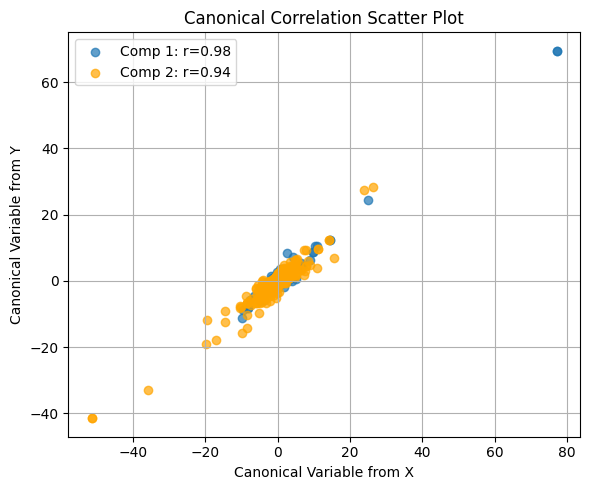

In [37]:

import matplotlib.pyplot as plt
# Scatter plot of canonical variates
plt.figure(figsize=(6, 5))
plt.scatter(X_c[:, 0], Y_c[:, 0], label=f"Comp 1: r={canonical_corrs[0]:.2f}", alpha=0.7)
plt.scatter(X_c[:, 1], Y_c[:, 1], label=f"Comp 2: r={canonical_corrs[1]:.2f}", alpha=0.7, color='orange')
plt.xlabel("Canonical Variable from X")
plt.ylabel("Canonical Variable from Y")
plt.title("Canonical Correlation Scatter Plot")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [1]:

import pickle
with open(f'results/IMDB_CLL_pca_30_5_pairs_0/0.3', 'rb') as fh:
        
    coarsener_imdb = pickle.load(fh) 

/scratch/0994359/hetero-conv-matching/.venv/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


In [9]:
import torch
coarsend_graph = coarsener_imdb.summarized_graph
coarsend_graph = coarsend_graph.to(device)
#coarsend_graph = coarsend_graph.cpu()
mapping = coarsener_imdb.get_mapping("movie")
coarsener_imdb.make_mask(mapping, "movie")

labels = coarsener_imdb.get_labels(mapping, "movie")
coarsend_graph.nodes["movie"].data["label"] = torch.tensor([labels[i] for i in range(len(labels)) ],  device=device) #,
print("ratio", coarsend_graph.num_nodes()/ original_graph.num_nodes() ) 


ratio 0.299931129476584


In [36]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.data import HeteroData

def run_experiments(original_graph, coarsend_graph, model_class, num_runs=5,
                    epochs=100, optimizer=torch.optim.Adam, target_node_type="movie",
                    model_param={"hidden_dim": 256},
                    optimizer_param={"lr": 0.01, "weight_decay": 5e-4},
                    device="cuda" if torch.cuda.is_available() else "cpu",
                    eval_interval=10, run_orig=True,
                    early_stopping_patience=30):

    original_accuracies = []
    coarsened_accuracies = []
    original_loss = []
    coarsened_loss = []

    for run in range(num_runs):
        train_idx_orig = torch.nonzero(original_graph.nodes[target_node_type].data["train_mask"]).squeeze()
        test_idx_orig = torch.nonzero(original_graph.nodes[target_node_type].data["test_mask"]).squeeze()
        val_idx_orig = torch.nonzero(original_graph.nodes[target_node_type].data["test_mask"]).squeeze()
        labels_orig = original_graph.nodes[target_node_type].data['label']

        train_idx_coar = torch.nonzero(coarsend_graph.nodes[target_node_type].data["train_mask"]).squeeze()
        test_idx_coar = torch.nonzero(coarsend_graph.nodes[target_node_type].data["test_mask"]).squeeze()
        val_idx_coar = torch.nonzero(coarsend_graph.nodes[target_node_type].data["test_mask"]).squeeze()
        labels_coar = coarsend_graph.nodes[target_node_type].data['label']

        metadata_orig = (original_graph.ntypes, original_graph.etypes)
        metadata_coar = (coarsend_graph.ntypes, coarsend_graph.etypes)

        feat_orig = {ntype: original_graph.nodes[ntype].data['feat'] for ntype in original_graph.ntypes}
        feat_coar = {ntype: coarsend_graph.nodes[ntype].data['feat'] for ntype in coarsend_graph.ntypes}
        
        output_dim = len(torch.unique(labels_orig))
        model_original = model_class(metadata=metadata_orig,
                                     x_dict=feat_orig,
                                     target_feat=target_node_type,
                                     out_dim=output_dim,
                                     **model_param).to(device)
        optimizer_original = optimizer(model_original.parameters(), **optimizer_param)

        model_coarsened = model_class(metadata=metadata_coar,
                                      x_dict=feat_coar,
                                      target_feat=target_node_type,
                                      out_dim=output_dim,
                                      **model_param).to(device)
        optimizer_coarsened = optimizer(model_coarsened.parameters(), **optimizer_param)

        def train(model, graph, feats, labels, train_idx, optimizer):
            model.train()
            optimizer.zero_grad()
            logits = model(graph, feats)[target_node_type]
            loss = F.cross_entropy(logits[train_idx], labels[train_idx])
            loss.backward()
            optimizer.step()
            return loss

        def test(model, graph, feats, labels, val_idx):
            model.eval()
            with torch.no_grad():
                logits = model(graph, feats)[target_node_type]
                preds = logits.argmax(dim=1)
                correct = (preds[val_idx] == labels[val_idx]).sum().item()
                return correct / val_idx.shape[0], preds

        original_acc_per_run = []
        coarsened_acc_per_run = []
        original_loss_per_run = []
        coarsened_loss_per_run = []

        best_val_acc_orig = 0
        best_val_acc_coar = 0
        patience_counter_orig = 0
        patience_counter_coar = 0
        stop_orig = False
        stop_coar = False

        for epoch in range(epochs):
            # Training only if not early-stopped
            if run_orig and not stop_orig:
                loss_orig = train(model_original, original_graph, feat_orig, labels_orig, train_idx_orig, optimizer_original)
            elif run_orig:
                loss_orig = torch.tensor(0.0)  # Dummy loss for shape consistency

            if not stop_coar:
                loss_coar = train(model_coarsened, coarsend_graph, feat_coar, labels_coar, train_idx_coar, optimizer_coarsened)
            else:
                loss_coar = torch.tensor(0.0)  # Dummy loss

            # Evaluate every eval_interval
            if epoch % eval_interval == 0:
                if run_orig:
                    val_acc_orig, _ = test(model_original, original_graph, feat_orig, labels_orig, val_idx_orig)
                    original_acc_per_run.append(val_acc_orig)
                    original_loss_per_run.append(loss_orig.item())

                    if not stop_orig:
                        if val_acc_orig > best_val_acc_orig:
                            best_val_acc_orig = val_acc_orig
                            patience_counter_orig = 0
                        else:
                            patience_counter_orig += 1
                            if patience_counter_orig >= early_stopping_patience:
                                stop_orig = True

                val_acc_coar, _ = test(model_coarsened, original_graph, feat_orig, labels_orig, val_idx_orig)
                coarsened_acc_per_run.append(val_acc_coar)
                coarsened_loss_per_run.append(loss_coar.item())

                if not stop_coar:
                    if val_acc_coar > best_val_acc_coar:
                        best_val_acc_coar = val_acc_coar
                        patience_counter_coar = 0
                    else:
                        patience_counter_coar += 1
                        if patience_counter_coar >= early_stopping_patience:
                            stop_coar = True

        # Final evaluation
        if run_orig:
            final_acc_orig, _ = test(model_original, original_graph, feat_orig, labels_orig, val_idx_orig)
            original_acc_per_run.append(final_acc_orig)
            original_accuracies.append(original_acc_per_run)
            original_loss.append(original_loss_per_run)

        final_acc_coar, _ = test(model_coarsened, original_graph, feat_orig, labels_orig, val_idx_orig)
        coarsened_acc_per_run.append(final_acc_coar)
        coarsened_accuracies.append(coarsened_acc_per_run)
        coarsened_loss.append(coarsened_loss_per_run)

    return original_accuracies, coarsened_accuracies, original_loss, coarsened_loss


In [ ]:
from Models.SimpleHeteroGCN import HeteroGCNCiteer    
from Models.ImprovedGCN import ImprovedGCN
from Models.HeteroSGC import HeteroSGC
import importlib
from Models.HeteroSage import HeteroSAGE

from Models.HeteroSGC import HeteroSGCPaper
# from Experiments.model_helper import run_experiments
from Experiments.plots import plot_bar, plot_line
orig, coar, loss_ori, loss_coar = run_experiments(original_graph, coarsend_graph,   HeteroSGCPaper, num_runs=1,
                                                  model_param={"hidden_dim": 64,"num_layers":4,} ,
                        optimizer_param={"lr": 0.01, "weight_decay": 5e-4}, epochs=1000,eval_interval=1, target_node_type="movie", device="cuda:1")
orig_short = [ o[-1] for o in orig ]
coar_short = [ o[-1] for o in coar ]
from Experiments.plots import plot_bar, plot_line

epochs = list(range(1000))
plot_line(orig[0], coar[0], loss_ori[0], loss_coar[0], epochs)
# plot_bar(orig_short, coar_short)

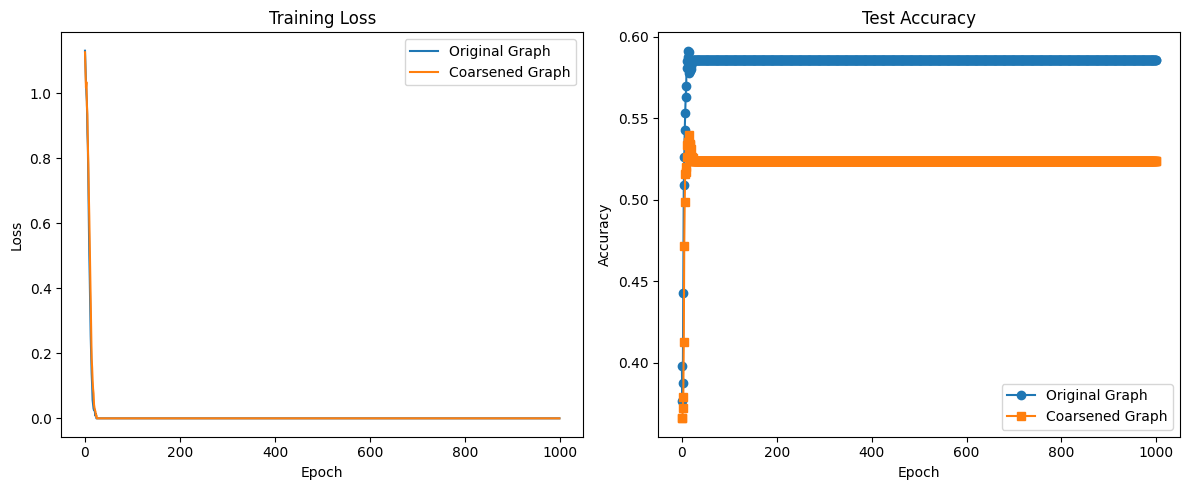

Final Performance Comparison:
Original Graph Accuracy: 0.5857
Coarsened Graph Accuracy: 0.5236

Original Graph Accuracy:
  Mean: 0.5857
  Std:  0.0000

Coarsened Graph Accuracy:
  Mean: 0.5236
  Std:  0.0000


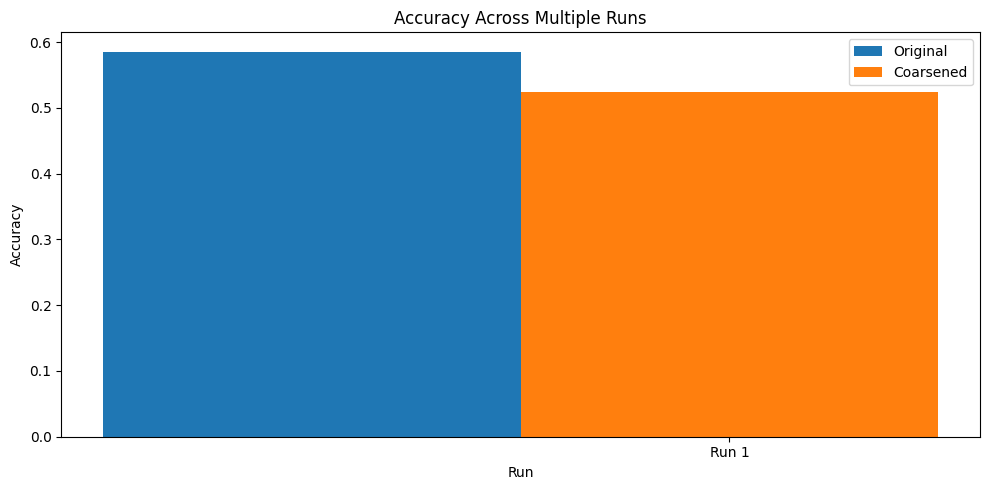

In [ ]:
from Models.SimpleHeteroGCN import HeteroGCNCiteer    
from Models.ImprovedGCN import ImprovedGCN
from Models.HeteroSGC import HeteroSGC
import importlib
from Models.HeteroSage import HeteroSAGE

from Models.HeteroSGC import HeteroSGCPaper
# from Experiments.model_helper import run_experiments
from Experiments.plots import plot_bar, plot_line
orig, coar, loss_ori, loss_coar = run_experiments(original_graph, coarsend_graph,   ImprovedGCN, num_runs=1,
                                                  model_param={"hidden_dim": 64,"num_layers":4,} ,
                        optimizer_param={"lr": 0.003, "weight_decay": 5e-4}, epochs=1000,eval_interval=1, target_node_type="movie", device="cuda:1")
orig_short = [ o[-1] for o in orig ]
coar_short = [ o[-1] for o in coar ]
from Experiments.plots import plot_bar, plot_line

epochs = list(range(1000))
plot_line(orig[0], coar[0], loss_ori[0], loss_coar[0], epochs)
# plot_bar(orig_short, coar_short)

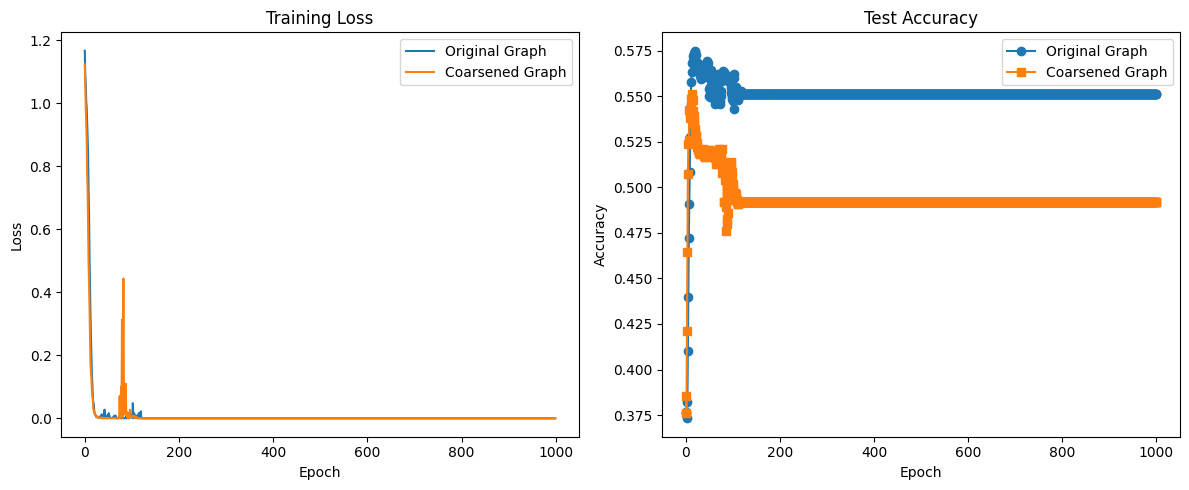

Final Performance Comparison:
Original Graph Accuracy: 0.5512
Coarsened Graph Accuracy: 0.4919


In [ ]:
from Models.SimpleHeteroGCN import HeteroGCNCiteer    
from Models.ImprovedGCN import ImprovedGCN
from Models.HeteroSGC import HeteroSGC
import importlib
from Models.HeteroSage import HeteroSAGE

from Models.HeteroSGC import HeteroSGCPaper
# from Experiments.model_helper import run_experiments
from Experiments.plots import plot_bar, plot_line
orig, coar, loss_ori, loss_coar = run_experiments(original_graph, coarsend_graph,   ImprovedGCN, num_runs=1,
                                                  model_param={"hidden_dim": 64,"num_layers":4,} ,
                        optimizer_param={"lr": 0.001, "weight_decay": 5e-4}, epochs=1000,eval_interval=1, target_node_type="movie", device="cuda:1")
orig_short = [ o[-1] for o in orig ]
coar_short = [ o[-1] for o in coar ]
from Experiments.plots import plot_bar, plot_line

epochs = list(range(1000))
plot_line(orig[0], coar[0], loss_ori[0], loss_coar[0], epochs)
# plot_bar(orig_short, coar_short)

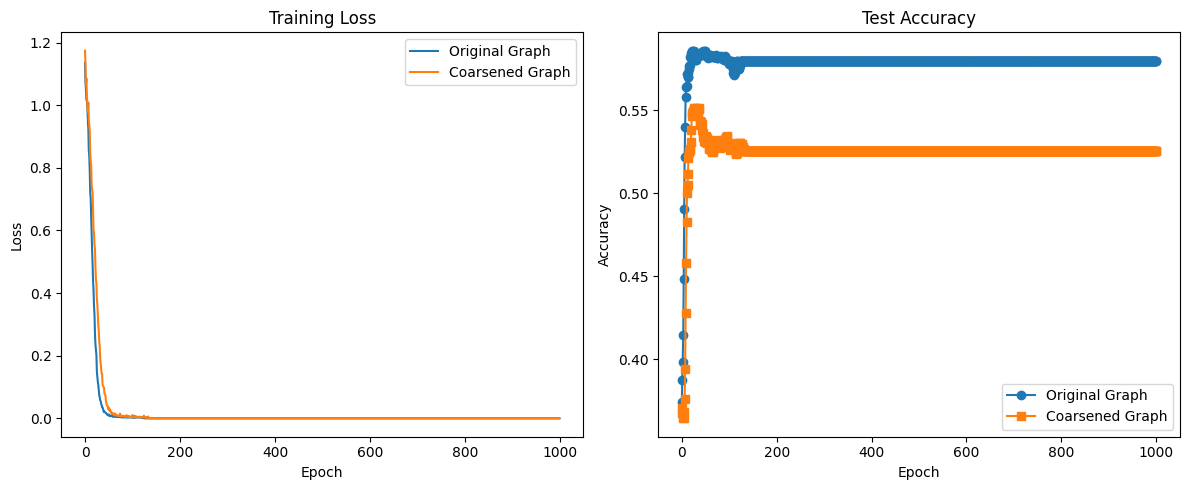

Final Performance Comparison:
Original Graph Accuracy: 0.5799
Coarsened Graph Accuracy: 0.5253


In [35]:
from Models.SimpleHeteroGCN import HeteroGCNCiteer    
from Models.ImprovedGCN import ImprovedGCN
from Models.HeteroSGC import HeteroSGC
import importlib
from Models.HeteroSage import HeteroSAGE

from Models.HeteroSGC import HeteroSGCPaper
# from Experiments.model_helper import run_experiments
from Experiments.plots import plot_bar, plot_line
orig, coar, loss_ori, loss_coar = run_experiments(original_graph, coarsend_graph,   ImprovedGCN, num_runs=1,
                                                  model_param={"hidden_dim": 64,"num_layers":4,} ,
                        optimizer_param={"lr": 0.001, "weight_decay": 5e-4}, epochs=1000,eval_interval=1, target_node_type="movie", device="cuda:1")
orig_short = [ o[-1] for o in orig ]
coar_short = [ o[-1] for o in coar ]
from Experiments.plots import plot_bar, plot_line

epochs = list(range(1000))
plot_line(orig[0], coar[0], loss_ori[0], loss_coar[0], epochs)
# plot_bar(orig_short, coar_short)

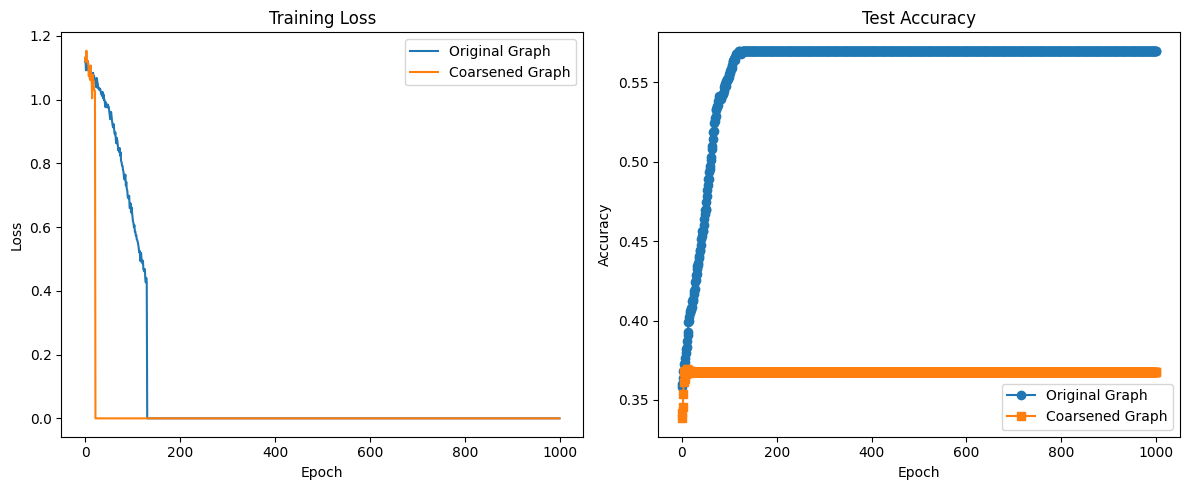

Final Performance Comparison:
Original Graph Accuracy: 0.5699
Coarsened Graph Accuracy: 0.3677


In [31]:
from Models.SimpleHeteroGCN import HeteroGCNCiteer    
from Models.ImprovedGCN import ImprovedGCN
from Models.HeteroSGC import HeteroSGC
import importlib
from Models.HeteroSage import HeteroSAGE

from Models.HeteroSGC import HeteroSGCPaper
# from Experiments.model_helper import run_experiments
from Experiments.plots import plot_bar, plot_line
orig, coar, loss_ori, loss_coar = run_experiments(original_graph, coarsend_graph,   ImprovedGCN, num_runs=1,
                                                  model_param={"hidden_dim": 64,"num_layers":4,} ,
                        optimizer_param={"lr": 0.0001, "weight_decay": 5e-4}, epochs=1000,eval_interval=1, target_node_type="movie", device="cuda:1")
orig_short = [ o[-1] for o in orig ]
coar_short = [ o[-1] for o in coar ]
from Experiments.plots import plot_bar, plot_line

epochs = list(range(1000))
plot_line(orig[0], coar[0], loss_ori[0], loss_coar[0], epochs)
# plot_bar(orig_short, coar_short)